In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread("Training_Data/example3.jpg")  # Replace with your actual image path

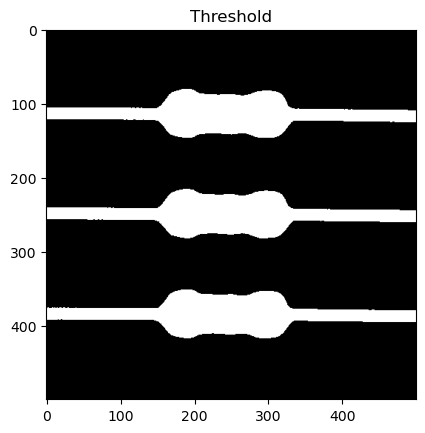

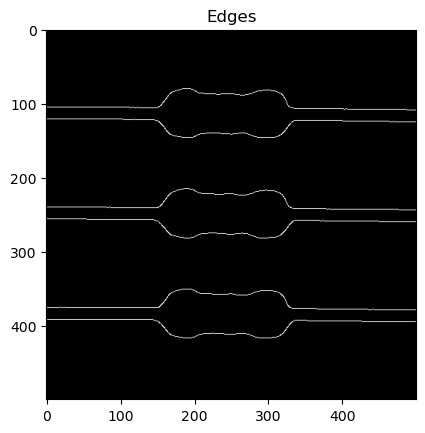

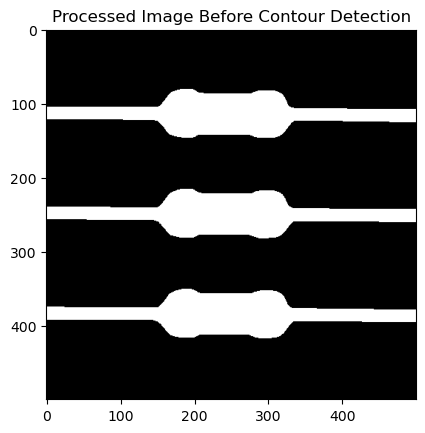

Contours detected before filtering: 3


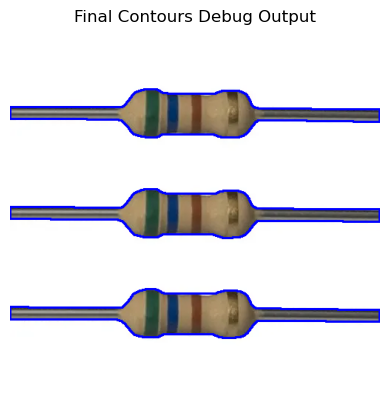

In [100]:
### **Step 1: Preprocessing**
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding to enhance object isolation
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap='gray')
plt.title("Threshold")
plt.show()

# Edge detection
edges = cv2.Canny(binary, 50, 250)

plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.show()

# Morphological operations for better shape closure
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
processed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=5)
processed = cv2.morphologyEx(processed, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(processed, cmap='gray')
plt.title("Processed Image Before Contour Detection")
plt.show()

# Find contours
contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Contours detected before filtering: {len(contours)}")

# Debugging: Visualize contours (Main Output)
debug_contours = img.copy()
cv2.drawContours(debug_contours, contours, -1, (255, 0, 0), 2)

# Display debug visualization as the main result
plt.imshow(cv2.cvtColor(debug_contours, cv2.COLOR_BGR2RGB))
plt.title("Final Contours Debug Output")
plt.axis("off")
plt.show()



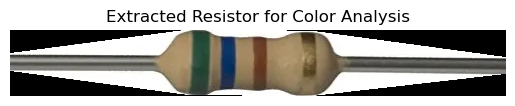

In [102]:
# Filter contours based on shape properties
filtered_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area != 0 else 0

    # Filtering criteria to remove metal leads
    if area > 100 and solidity > 0.63:
        filtered_contours.append(hull)  # Store only the valid resistor contour

# Ensure at least one contour was found
if not filtered_contours:
    print("Error: No valid resistor contour detected.")
    exit()

# Create a blank mask
mask = np.zeros_like(gray)

# Fill the contour on the mask (keeping only the resistor body)
cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

# Apply the mask to the original image
extracted_resistor = cv2.bitwise_and(img, img, mask=mask)

# Find bounding box and crop the resistor
x, y, w, h = cv2.boundingRect(filtered_contours[0])  # Assuming the largest contour is the resistor
cropped_resistor = extracted_resistor[y:y+h, x:x+w]  # Crop only the resistor region

# Show the isolated resistor
plt.imshow(cv2.cvtColor(cropped_resistor, cv2.COLOR_BGR2RGB))
plt.title("Extracted Resistor for Color Analysis")
plt.axis("off")
plt.show()

In [104]:
# SHARPEN
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5,-1],
    [0, -1, 0]
])
sharpened = cv2.filter2D(cropped_resistor, -1, sharpen_kernel)

# CLAHE for vibrant colors
hsv_sharp = cv2.cvtColor(sharpened, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_sharp)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
v_clahe = clahe.apply(v)

enhanced_hsv = cv2.merge((h, s, v_clahe))
vibrant_resistor = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

# denoising
vibrant_resistor = cv2.bilateralFilter(vibrant_resistor, 9, 75, 75)

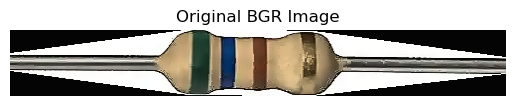

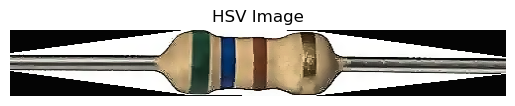

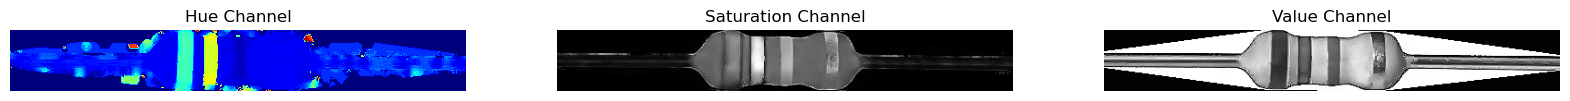

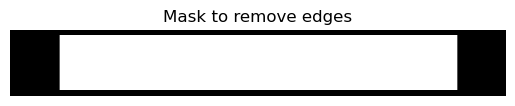

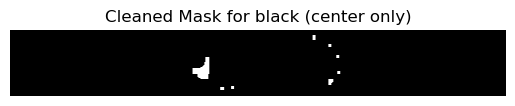

Filtered vertical band contours for black: 0


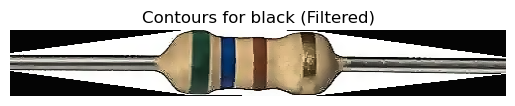

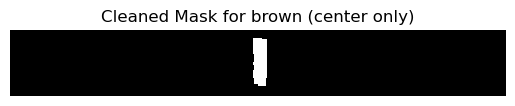

Filtered vertical band contours for brown: 1


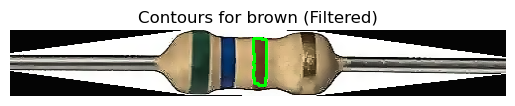

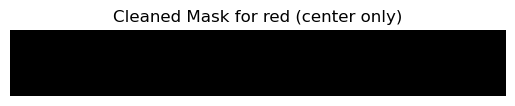

Filtered vertical band contours for red: 1


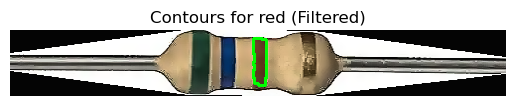

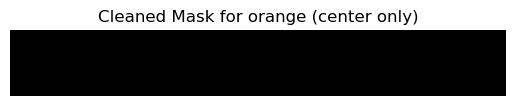

Filtered vertical band contours for orange: 1


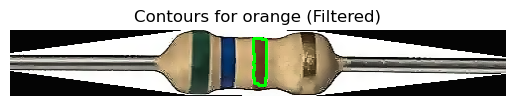

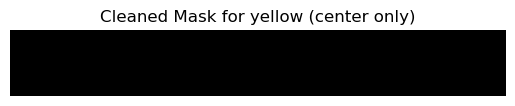

Filtered vertical band contours for yellow: 1


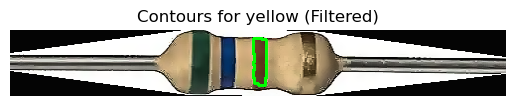

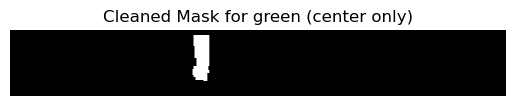

Filtered vertical band contours for green: 1


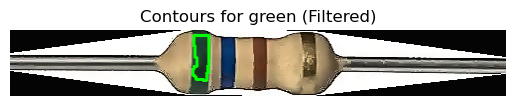

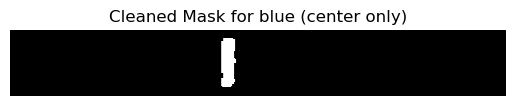

Filtered vertical band contours for blue: 1


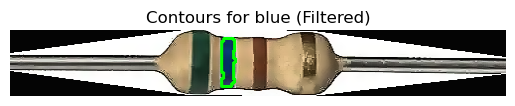

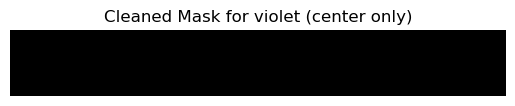

Filtered vertical band contours for violet: 1


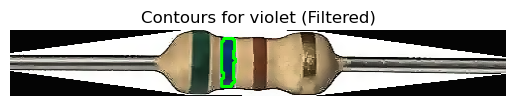

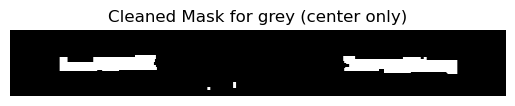

Filtered vertical band contours for grey: 0


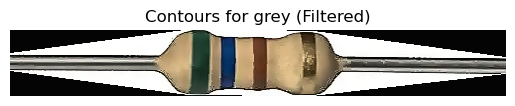

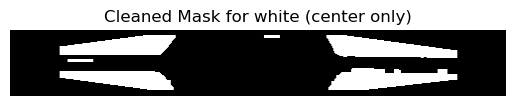

Filtered vertical band contours for white: 0


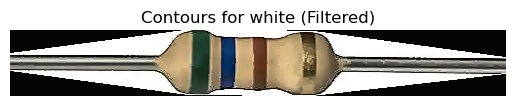

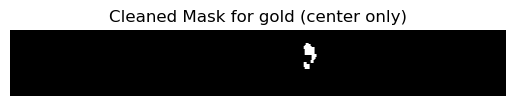

Filtered vertical band contours for gold: 1


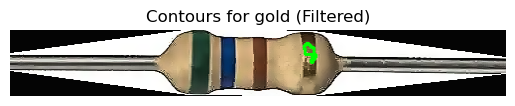

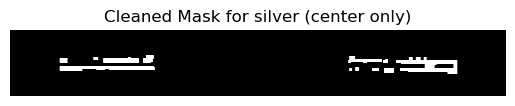

Filtered vertical band contours for silver: 0


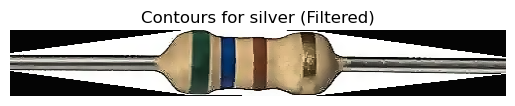

In [110]:
### **Step 3: Color Classification for Resistor Bands**

plt.imshow(cv2.cvtColor(vibrant_resistor, cv2.COLOR_BGR2RGB))
plt.title("Original BGR Image")
plt.axis("off")
plt.show()

# Convert to HSV for color segmentation
img_hsv = cv2.cvtColor(vibrant_resistor, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
plt.title("HSV Image")
plt.axis("off")
plt.show()

h, s, v = cv2.split(img_hsv)

h_normalized = (h * 255 / 179).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(h, cmap="jet"), axes[0].set_title("Hue Channel"), axes[0].axis("off")
axes[1].imshow(s, cmap="gray"), axes[1].set_title("Saturation Channel"), axes[1].axis("off")
axes[2].imshow(v, cmap="gray"), axes[2].set_title("Value Channel"), axes[2].axis("off")

plt.show()

# Define HSV color ranges for resistor bands
color_ranges = {
    'black': [(0, 0, 5), (180, 255, 50)],
    'brown': [(7, 120, 50), (14, 255, 150)],
    'red': [(0, 180, 100), (10, 255, 255)],
    'orange': [(10, 150, 170), (25, 255, 255)],
    'yellow': [(25, 100, 100), (35, 255, 255)],
    'green': [(35, 100, 40), (85, 255, 255)],
    'blue': [(85, 100, 50), (130, 255, 255)],
    'violet': [(130, 50, 50), (160, 255, 255)],
    'grey': [(0, 0, 50), (180, 50, 200)],
    'white': [(0, 0, 200), (180, 30, 255)],
    'gold': [(15, 120, 100), (35, 240, 200)],
    'silver': [(0, 0, 100), (180, 30, 200)],
}

height, width = img_hsv.shape[:2]
# Create a binary mask with 1s in the middle, 0s on borders
resistor_mask = np.zeros((height, width), dtype=np.uint8)
cv2.rectangle(resistor_mask, (int(0.1*width), int(0.1*height)), (int(0.9*width), int(0.9*height)), 255, -1)
plt.imshow(resistor_mask, cmap="gray")
plt.title(f"Mask to remove edges")
plt.axis("off")
plt.show()

kernel = np.ones((3, 3), np.uint8)

for color, (lower, upper) in color_ranges.items():
    # Create a mask for the color
    mask = cv2.inRange(img_hsv, np.array(lower), np.array(upper))

    # Apply the resistor center mask to ignore edges
    masked = cv2.bitwise_and(mask, resistor_mask)

    # Apply morphological operations to clean up the mask
    masked_cleaned = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel)  # Dilation followed by erosion
    masked_cleaned = cv2.morphologyEx(masked_cleaned, cv2.MORPH_OPEN, kernel)  # Erosion followed by dilation

    # Show the result of the final masked region
    plt.imshow(masked_cleaned, cmap="gray")
    plt.title(f"Cleaned Mask for {color} (center only)")
    plt.axis("off")
    plt.show()

    # Use the cleaned masked version for contour detection
    contours, _ = cv2.findContours(masked_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = h / float(w) if w != 0 else 0

        area = cv2.contourArea(cnt)

        # Only keep reasonably vertical and rectangular bands
    if area > 15 and aspect_ratio > 1.2 and h > 5 and w > 0.5:
        filtered_contours.append(cnt)

    print(f"Filtered vertical band contours for {color}: {len(filtered_contours)}")

    # Optional: draw them if you want to visualize
    preview = vibrant_resistor.copy()  # Use your denoised image if you applied one earlier
    cv2.drawContours(preview, filtered_contours, -1, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours for {color} (Filtered)")
    plt.axis("off")
    plt.show()

In [114]:
band_info = []

for color, (lower, upper) in color_ranges.items():
    mask = cv2.inRange(img_hsv, np.array(lower), np.array(upper))
    masked = cv2.bitwise_and(mask, resistor_mask)
    masked_cleaned = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel)
    masked_cleaned = cv2.morphologyEx(masked_cleaned, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(masked_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 20:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = h / float(w) if w != 0 else 0

        # Add condition for relatively vertical and rectangular strips
        if 1.5 < aspect_ratio < 10 and w > 2 and h > 5:  # Adjust thresholds as needed
            cx = x + w // 2
            band_info.append((cx, color))
            # Optional: draw the box for debug
            cv2.rectangle(cropped_resistor, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Sort the bands left to right
band_info.sort(key=lambda x: x[0])
band_colors = [color for _, color in band_info]

print("Detected band colors:", band_colors)

color_digit = {
    'black': 0, 'brown': 1, 'red': 2, 'orange': 3,
    'yellow': 4, 'green': 5, 'blue': 6, 'violet': 7,
    'grey': 8, 'white': 9
}

multiplier_map = {
    'black': 1, 'brown': 10, 'red': 100, 'orange': 1_000,
    'yellow': 10_000, 'green': 100_000, 'blue': 1_000_000,
    'gold': 0.1, 'silver': 0.01
}

def calculate_resistor_value(bands):
    if len(bands) == 4:
        digit1 = color_digit.get(bands[0], 0)
        digit2 = color_digit.get(bands[1], 0)
        multiplier = multiplier_map.get(bands[2], 1)
        return (10 * digit1 + digit2) * multiplier
    elif len(bands) == 5:
        digit1 = color_digit.get(bands[0], 0)
        digit2 = color_digit.get(bands[1], 0)
        digit3 = color_digit.get(bands[2], 0)
        multiplier = multiplier_map.get(bands[3], 1)
        return (100 * digit1 + 10 * digit2 + digit3) * multiplier
    else:
        return None

value = calculate_resistor_value(band_colors)
if value:
    print(f"Resistor value: {value} ohms")
else:
    print("Could not determine resistor value.")


Detected band colors: ['green', 'blue', 'brown', 'gold']
Resistor value: 560 ohms
